In [2]:
import pandas as pd
# from google.colab import files

import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random

In [5]:
data = pd.read_csv("광진구데이터프레임.csv")
data

,학원명,도로명주소,위도,경도,정원합계,일시수용능력인원합계,인원,근처학원수,근처수강생총합,근처휴게음식점수,근처횡단보도수,사고건수
0,생명을살리는수학창의교육보습학원,서울특별시 광진구 구의강변로 106,37.539900,127.094819,24,85.0,24.0,221.0,11724.0,188.0,124.0,4.0
1,시엘음악학원,서울특별시 광진구 용마산로21길 27,37.563485,127.085939,40,63.0,40.0,46.0,2822.0,73.0,79.0,12.0
2,성신에듀학원,서울특별시 광진구 자양로22길 24,37.539490,127.084692,255,53.0,53.0,47.0,2527.0,83.0,53.0,17.0
3,청람보습학원,서울특별시 광진구 용마산로 100,37.562608,127.087319,90,90.0,90.0,42.0,2699.0,45.0,77.0,14.0
4,상명보습학원,서울특별시 광진구 자양로 181-1,37.543898,127.084563,59,115.0,59.0,44.0,1553.0,62.0,12.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...
780,하이클래스보습학원,서울특별시 광진구 뚝섬로 655,37.531600,127.082320,136,77.0,77.0,55.0,2363.0,77.0,61.0,10.0
781,해법영어최선엘리트학원,서울특별시 광진구 천호대로 136길 46,37.547763,127.090071,170,68.0,68.0,49.0,2082.0,35.0,59.0,12.0
782,에이스에듀케이션학원,서울특별시 광진구 아차산로 471,37.540413,127.093944,48,128.0,48.0,212.0,11728.0,196.0,131.0,6.0
783,숨피아노교습소,서울특별시 광진구 동일로26길 46,37.544708,127.068316,40,9.0,9.0,23.0,1758.0,132.0,53.0,17.0


In [32]:
import collections
# 정원 수 100명 이상
# 근처수강생총합, 근처휴게음식점수 상위 50% 사고건수 0이상으로 나온 학원들을 추려 후보지로.
# 사고 건수 0 이상으로 하긴 했는데 ppt 에는 50%로 두고 해당 변수들이 다 겹치는 교집합 학원을 후보지로
l1 = data[data['인원']>=100].index.to_list()
l2 = data[data['근처수강생총합']>=data['근처수강생총합'].quantile(0.5)].index.to_list()
l3 = data[data['근처휴게음식점수']>=data['근처휴게음식점수'].quantile(0.5)].index.to_list()
# l4 = data[data['사고건수']>=data['사고건수'].quantile(0.5)].index.to_list()
l4 = data[data['사고건수']>0].index.to_list()

intersection = list(set(l1) & set(l2) & set(l3)&set(l4))

In [33]:
len(intersection)

35

In [34]:
candidate_frame = data.loc[intersection, :].reset_index(drop=True)
candidate_frame

,학원명,도로명주소,위도,경도,정원합계,일시수용능력인원합계,인원,근처학원수,근처수강생총합,근처휴게음식점수,근처횡단보도수,사고건수
0,임박사의일본가자통역학원,서울특별시 광진구 구의강변로 83,37.538148,127.093503,278,139.0,139.0,160.0,9004.0,245.0,136.0,6.0
1,크레버스영재교육센터광진제1지점학원,서울특별시 광진구 광나루로 603,37.542015,127.095597,100,120.0,100.0,214.0,11565.0,186.0,98.0,2.0
2,광진일관정상어학원,서울특별시 광진구 아차산로 462,37.539496,127.093418,160,120.0,120.0,207.0,11356.0,228.0,137.0,6.0
3,광진심슨어학보습학원,서울특별시 광진구 광나루로 604,37.541573,127.094910,780,280.0,280.0,209.0,11247.0,186.0,91.0,2.0
4,웅진씽크빅학습센터광장학원,서울특별시 광진구 광나루로 607,37.541961,127.095718,155,124.0,124.0,215.0,11679.0,186.0,96.0,2.0
5,클라비스수학학원,서울특별시 광진구 구의로16길 89,37.541695,127.094384,420,103.0,103.0,210.0,11340.0,191.0,95.0,4.0
6,웅진프라임학원,서울특별시 광진구 광나루로 590,37.542576,127.093917,100,108.0,100.0,201.0,11309.0,174.0,81.0,4.0
7,최선생수학본영어학원,서울특별시 광진구 광나루로 602,37.541787,127.094700,250,112.0,112.0,209.0,11323.0,186.0,96.0,4.0
8,자양심슨어학학원,서울특별시 광진구 뚝섬로 552,37.534244,127.071276,900,296.0,296.0,109.0,4106.0,152.0,59.0,7.0
9,샤인영어학원,서울특별시 광진구 아차산로65길 14,37.541047,127.094089,106,136.0,106.0,203.0,11450.0,193.0,118.0,2.0


In [36]:
can_points = np.array([list(i) for i in zip(candidate_frame['경도'], candidate_frame['위도'])])

In [37]:
all_points = np.array([list(i) for i in zip(data['경도'], data['위도'])])

In [38]:
import pandas as pd
# from google.colab import files

import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random

In [42]:
def mclp(points,K,radius,M):
    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = can_points #후보지 전체
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

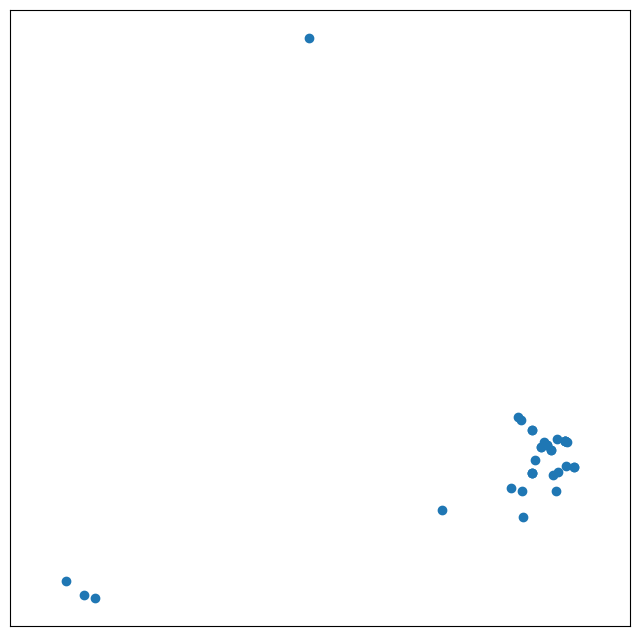

In [46]:
plot_input(can_points)

----- Configurations -----
  Number of points 785
  K 10
  Radius 0.005
  M 35
----- Output -----
  Running time : 0.02085709571838379 seconds
  Optimal coverage points: 436


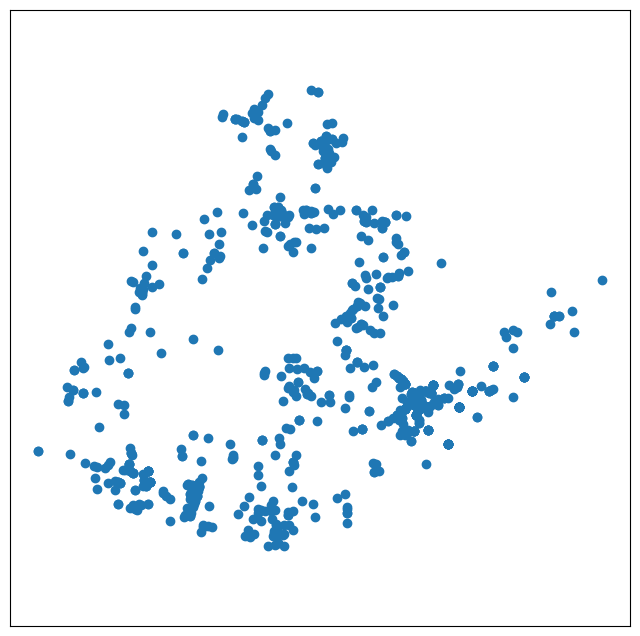

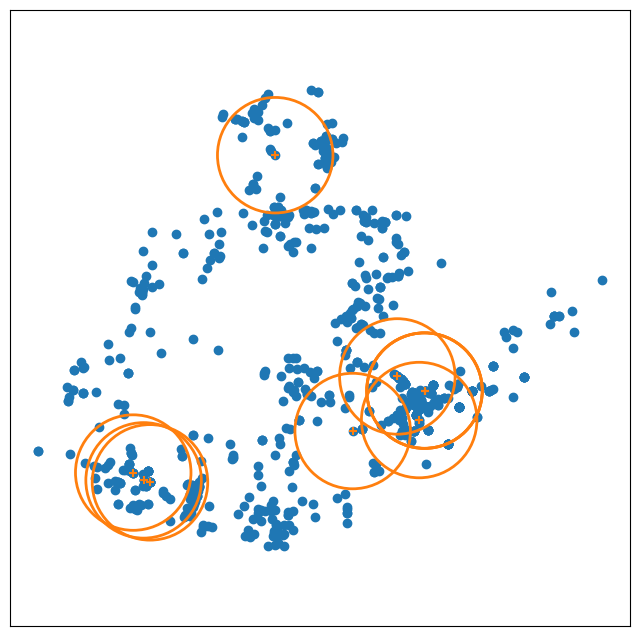

In [48]:
# Plot input data
plot_input(all_points)

# 최종 후보 정할 개수
K = 10 # 10개를 최종 후보로 선정

# Service radius of each site
radius = 0.005 # 위도경도 기준 대략 1km - 후보지 중 총 학원 수를 많이 커버하는 후보지 찾음.

# Candidate site size == 후보지로 뽑은 총 개수
M = len(can_points)

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,f = mclp(all_points,K,radius,M)

# Plot the result
plot_result(all_points,opt_sites,radius)